Just importing the necessary libraries to work with the data.

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mplt

Reading the dataset.

In [43]:
ships = pd.read_csv('D:/airbus/train_ship_segmentations_v2.csv')
ships.head(10)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


In [5]:
ships.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


What can be seen:
- The 1st row of the table contains ids of images from the training set, the 2nd row contains an rle encoding of the mask
- Most of the images don't have any ships, only 82k of them have 1 or more ships

While it would be useful to keep some of the empty images around, I am going to drop all the images that do not have a ship, mainly so that image processing and training don't take a ridiculous amount of time.

In [49]:
ships_nonempty = ships.dropna().reset_index(drop=True)
ships_nonempty.head(10)

,ImageId,EncodedPixels
0,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
1,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
2,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
3,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
4,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
5,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
6,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...
7,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...
8,00021ddc3.jpg,74441 3 75207 5 75975 5 76743 5 77511 5 78280 ...
9,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...


In [50]:
ships_nonempty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81723 entries, 0 to 81722
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        81723 non-null  object
 1   EncodedPixels  81723 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


Next, I will need an rle decoder to get the masks (code taken from the internet).

In [54]:
def rle_decode(mask_rle, shape):
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1

    return img.reshape(shape).T

Here is the original image:

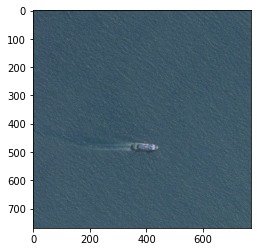

In [78]:
img = mpimg.imread(f'D:/airbus/train_v2/{ships_nonempty.ImageId[0]}')
plt.imshow(img)
plt.show()

Here is it's mask:

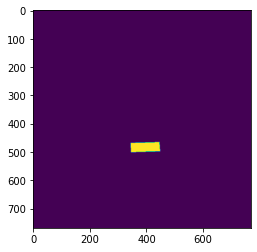

In [79]:
mask = ships_nonempty["EncodedPixels"][0]

mask = rle_decode(mask, (768, 768))
plt.imshow(mask)
plt.show()

Importing the pillow library to work with images.

In [57]:
from PIL import Image

I am going to resize all the images to 128x128. Working with 768x768 images will take a a very long time, both for image processing and especially for model training. The main goal of the project is simply to try and develop a u-net model and test it a little, so this should be fine.

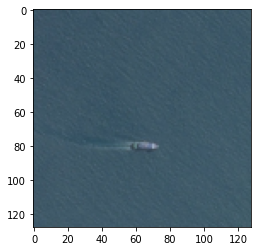

In [80]:
train_ids = ships_nonempty['ImageId']
img = Image.open(f'D:/airbus/train_v2/{train_ids[0]}')
newimg = img.resize((128,128))
plt.imshow(newimg)
plt.show()

Next, I am going to convert all training images into 128x128x3 arrays to serve as inputs for the model.

In [ ]:
X_train = np.zeros((len(train_ids),128,128,3),dtype=np.uint8)
i = 0
for trainid in train_ids:
    img = Image.open(f'D:/airbus/train_v2/{trainid}')
    newimg = img.resize((128,128))
    X_train[i] = newimg
    i += 1

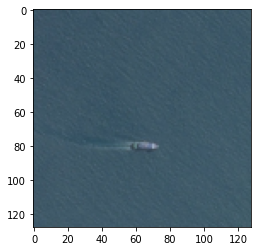

In [68]:
plt.imshow(X_train[0])
plt.show()

Now, let's see how resizing will affect the masks.

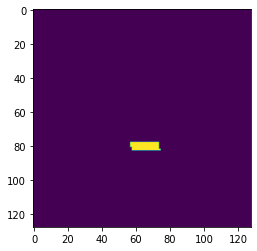

In [81]:
mask = ships_nonempty["EncodedPixels"][0]
mask = rle_decode(mask, (768, 768))
img = Image.fromarray(mask)
newimg = img.resize((128,128))
plt.imshow(newimg)
plt.show()

It's clear to see that the quality is noticeably worse (the bottom part of the ship is significantly offset compared to the original image), but it is what it is.<br>
Time to put the masks into an array.

In [76]:
Y_train = np.zeros((len(train_ids),128,128),dtype=np.uint8)
i = 0
for i in np.arange(0, len(train_ids)):
    mask = ships_nonempty["EncodedPixels"][i]
    mask = rle_decode(mask, (768, 768))
    img = Image.fromarray(mask)
    newimg = img.resize((128,128))
    Y_train[i] = newimg

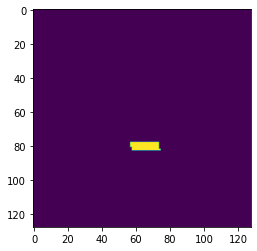

In [77]:
plt.imshow(Y_train[0])
plt.show()

Now, the training data is ready to be plugged into the model. Obviously, the architecture is going to be u-net (typically preferred for image segmentation tasks). For the metric I am going to use Accuracy. I know, it is advised to use dice score for this task, but tf.keras doesn't have a built-in implementation of it, and when I tried to define it myself, there was a conflict with data types (I would have to convert image arrays into float, and the amount of memory that would take is enormous). There are roughly 82k images, so I am going to do batches of 100, and after seeing how long each epoch was taking, I decided to settle on 2 epochs. 